# Timing Resolution

* Utilize pre-trained NF model to sample timings
* Calculate timing resolution of sampled timings
* Calculate timing resolution of optical photon hit times
* Compare std and mean of first hit timing distribution

## Setup
**Package imports:**

In [1]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
from IPython.display import clear_output
import time
from concurrent.futures import ThreadPoolExecutor
import matplotlib.ticker as plticker
import os
from typing import Union, List
from scipy.stats import norm
import os

**local imports (written by me):**

In [2]:
from NF_util import process_data, create_dataloader, prepare_data_for_nn,\
    create_unique_mapping,process_data_one_segment,\
    prepare_data_for_nn_one_segment, PVect, calculate_num_pixels_z_dependence,theta_func, r_func,load_real_data, process_times,get_all_times,checkdir

In [3]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Set parameters of model and data

In [4]:
import datetime
today = datetime.datetime.now().strftime("%B_%d")

In [19]:
# This data will be used for storing plots - today above works if you actually want today
# today = "August_07"

run_num = 14
run_num_str = str(run_num)

#NF Stuff

K = 4 #num flows

latent_size = 1 #dimension of PDF
hidden_layers = 10
hidden_units = 56 #nodes in hidden layers
context_size = 3 #conditional variables for PDF
num_context = 3
batch_size= 20000

K_str = str(K)
hidden_units_str = str(hidden_units)
hidden_layers_str = str(hidden_layers)
batch_size_str = str(batch_size)

## Neural Spline Flow
model definition:

In [22]:
# Set base distribution
from normflows.distributions import BaseDistribution
class DiagGaussian(BaseDistribution):
    """
    Multivariate Gaussian distribution with diagonal covariance matrix
    """

    def __init__(self, shape, trainable=True):
        """Constructor

        Args:
          shape: Tuple with shape of data, if int shape has one dimension
          trainable: Flag whether to use trainable or fixed parameters
        """
        super().__init__()
        if isinstance(shape, int):
            shape = (shape,)
        if isinstance(shape, list):
            shape = tuple(shape)
        self.shape = shape
        self.n_dim = len(shape)
        self.d = np.prod(shape)
        if trainable:
            self.loc = nn.Parameter(torch.zeros(1, *self.shape))
            self.log_scale = nn.Parameter(torch.zeros(1, *self.shape))
        else:
            self.register_buffer("loc", 4.5 * torch.ones(1, *self.shape))
            self.register_buffer("log_scale", torch.zeros(1, *self.shape))
        self.temperature = None  # Temperature parameter for annealed sampling

    def forward(self, num_samples=1, context=None):
        eps = torch.randn(
            (num_samples,) + self.shape, dtype=self.loc.dtype, device=self.loc.device
        )
        if self.temperature is None:
            log_scale = self.log_scale
        else:
            log_scale = self.log_scale + np.log(self.temperature)
        z = self.loc + torch.exp(log_scale) * eps
        log_p = -0.5 * self.d * np.log(2 * np.pi) - torch.sum(
            log_scale + 0.5 * torch.pow(eps, 2), list(range(1, self.n_dim + 1))
        )
        return z, log_p

    def log_prob(self, z, context=None):
        if self.temperature is None:
            log_scale = self.log_scale
        else:
            log_scale = self.log_scale + np.log(self.temperature)
        log_p = -0.5 * self.d * np.log(2 * np.pi) - torch.sum(
            log_scale + 0.5 * torch.pow((z - self.loc) / torch.exp(log_scale), 2),
            list(range(1, self.n_dim + 1)),
        )
        return log_p
q0 = DiagGaussian(1, trainable=False) #Typical use

In [23]:
flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
# q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)


Create directories / pick where to pull from

In [25]:
# model_date = "July_22"
# model_date = "Jan_28"
# model_date = "January_30" #Run 1
# model_date = "January_31" #Runs 3-8
# model_date = "February_01" #Runs 9
# model_date = "February_02" #Run 10-13
model_date = "February_03" #Run 14

model_path = "models/" + model_date + "/"
checkdir(model_path)

samples_path = "data/samples/" + today + "/"
checkdir(samples_path)

test_data_path = "data/test/" + today + "/"
checkdir(test_data_path)

test_dist_path = "plots/test_distributions/" + today + "/"
checkdir(test_dist_path)

Load model accoring to params above

In [26]:
# model.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_"\
#            + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs_checkpoint_e8.pth")
model.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_"\
           + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs_epoch9_step8765.pth")
# perm_model_dir = "/hpc/group/vossenlab/rck32/NF_time_res_models/"
# model.load(perm_model_dir+ "run_7_3context_8flows_26hl_256hu_2000bs.pth")
model = model.to(device)

model_compile = torch.compile(model,mode = "reduce-overhead")
model_compile = model_compile.to(device)

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/normflows/core.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


### Evaluation
load one bar scint root files with uproot

In [27]:
'''muon z pos vary'''

# Specify the directory path
directory = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_scint/January_28/"
filename = "run_1_mum_10GeV_theta_90_5kevents.edm4hep.root"


file_path = os.path.join(directory, filename)
data = process_data_one_segment(file_path + ":events")

features, metadata= prepare_data_for_nn_one_segment(data)

In [28]:
# Create DataLoader
batch_size_inference = 20000
dataloader = create_dataloader(features, metadata, batch_size_inference,shuffle_bool=False)

min_time = 0
samples = torch.empty(features.shape[0],device = device)
context = torch.empty((features.shape[0],3),device = device)
event_idxs = torch.empty(features.shape[0],device = device)
it = 0
with torch.no_grad():
    for batch_features, batch_metadata in dataloader:
        context_features = batch_features[:, :3].clone().to(device)
        samples[batch_size_inference * it:(batch_size_inference * it) + len(batch_features)] = abs(model_compile.sample(num_samples=context_features.shape[0], context=context_features)[0]).squeeze(1)
        samples[it*batch_size_inference:(batch_size_inference * it) + len(batch_features)].add_(batch_features[:, 3].to(device))
        context[batch_size_inference * it:(batch_size_inference * it) + len(batch_features)] = context_features
        event_idxs[batch_size_inference * it:(batch_size_inference * it) + len(batch_features)] = batch_metadata
        
        del batch_features
        it += 1
context = context.cpu().detach()
samples = samples.cpu().detach()
event_idxs = event_idxs.cpu().detach()

(402019, 4)


## Timing Resolution
Need distribution of time of first photons

#### NF: Calculate first pixel times for events that pass threshold

In [29]:
threshold = 10
first_times = []
# Get unique event indices and their counts
unique_events, counts = torch.unique(event_idxs, return_counts=True)

# Find events that meet the threshold
valid_events = unique_events[counts > threshold]

# If there are valid events, process them
if valid_events.numel() > 0:
    # Create a mask for valid events
    mask = torch.isin(event_idxs, valid_events)

    # Get samples and events for valid events
    valid_samples = samples[mask]
    valid_event_indices = event_idxs[mask]

    # Sort samples and event indices
    sorted_indices = torch.argsort(valid_event_indices)
    sorted_samples = valid_samples[sorted_indices]
    sorted_events = valid_event_indices[sorted_indices]

    # Find the minimum sample for each event
    unique_events = torch.unique(sorted_events)
    min_samples = torch.tensor([sorted_samples[sorted_events == event].min() for event in unique_events])
    second_min_samples = torch.tensor([sorted_samples[sorted_events == event].kthvalue(2)[0] for event in unique_events])

    # Append to the corresponding sublist in the result list
    first_times.append(min_samples.tolist())

#### Optph: process times and get distribution

In [13]:
from NF_util import avg_time
def process_times(uproot_path,threshold = 10, multipleFiles = False):
    if(multipleFiles):
        times_arrays_list = []
        cells_arrays_list = []
        x_pos_arrays_list = []
        y_pos_arrays_list = []
        z_pos_arrays_list = []
        px_arrays_list = []
        py_arrays_list = []
        pz_arrays_list = []

        # Loop through all files in the directory
        for file_name in os.listdir(uproot_path):
            if file_name.endswith(".root"):  # Ensure we're only processing ROOT files
                file_path = os.path.join(uproot_path, file_name)

                # Open the ROOT file
                with up.open(file_path) as file:
                    # Open tree
                    tree = file["events"]

                    times_arrays_list.append(tree["HcalBarrelHits/HcalBarrelHits.time"].array(library="np"))
                    cells_arrays_list.append(tree["HcalBarrelHits/HcalBarrelHits.cellID"].array(library="np"))
                    x_pos_arrays_list.append(tree["HcalBarrelHits/HcalBarrelHits.position.x"].array(library="np"))
                    y_pos_arrays_list.append(tree["HcalBarrelHits/HcalBarrelHits.position.y"].array(library="np"))
                    z_pos_arrays_list.append(tree["HcalBarrelHits/HcalBarrelHits.position.z"].array(library="np"))
                    
                    px_arrays_list.append(tree["HcalBarrelHits/HcalBarrelHits.momentum.x"].array(library="np"))
                    py_arrays_list.append(tree["HcalBarrelHits/HcalBarrelHits.momentum.y"].array(library="np"))
                    pz_arrays_list.append(tree["HcalBarrelHits/HcalBarrelHits.momentum.z"].array(library="np"))

        # Combine arrays for each branch
        times = np.concatenate(times_arrays_list)
        cells = np.concatenate(cells_arrays_list)
        x_pos_branch = np.concatenate(x_pos_arrays_list)
        y_pos_branch = np.concatenate(y_pos_arrays_list)
        z_pos_branch = np.concatenate(z_pos_arrays_list)

        # Now combined_arrays contains the concatenated arrays for each branch across all files
    else:
        events = up.open(uproot_path)

        times = events["HcalBarrelHits/HcalBarrelHits.time"].array(library='np')
        cells = events["HcalBarrelHits/HcalBarrelHits.cellID"].array(library='np')
        x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
        y_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.y"].array(library='np')
        z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')
        
    accepted_times = []
    second_lowest_list = []
    avg_accepted_times = []
    rel_accepted_times = []

    duplicates = 0
    total = 0
    total_cells = []

    skipped = 0
    num_list = []
    #First loop over events
    for event_num in range(len(cells)):

        #skip events with less than 2 photons
    #     if(times[event_num].shape[0] < threshold): continue

        #Keep track of which cell IDs are hit
        curr_list = []
        for photon_num in range(len(cells[event_num])):
            if(cells[event_num][photon_num] in curr_list):
                duplicates += 1
            else:
                curr_list.append(cells[event_num][photon_num])
            if(cells[event_num][photon_num] not in total_cells):
                total_cells.append(cells[event_num][photon_num])
            total += 1
        num_list.append(len(curr_list))
        #check if 2 unique pixels are hit
        if(len(curr_list) < threshold): 
            skipped += 1
            continue
        curr_min = min(times[event_num])
        accepted_times.append(curr_min)
        second_lowest_list.append(min([x for x in times[event_num] if x != curr_min]))
        avg_accepted_times.append(avg_time(threshold,times[event_num]))
    #     if(len(curr_list) == 15):
    #         print(f"event #{event_num}")
    print(f"total: {total} | duplicates: {duplicates} | ratio: {duplicates / total} | num unique cells hit: {len(total_cells)} | skipped: {skipped}")
    return accepted_times, second_lowest_list, avg_accepted_times, times

In [14]:
#Minimum number of pixels to be hit for us to accept event
threshold = 4


uproot_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_sensor/January_27/run_1_w_QE_2cm_thickness"

# uproot_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_sensor/October_24/run_1_w_QE"

accepted_times, second_lowest_list, avg_accepted_times, times = process_times(uproot_path, threshold,True)

total: 876688 | duplicates: 57574 | ratio: 0.06567216615261073 | num unique cells hit: 6532 | skipped: 1


In [15]:
all_times_optph = []
for event_idx in range(len(times)):
    for time in times[event_idx]:
        all_times_optph.append(time)

### Compare first photon distributions

In [16]:
np_first_times = np.array(first_times)

np_accepted_times = np.array(accepted_times)
ub = 10.8
lb = 10.2
cut_first_times = np_first_times[np_first_times < ub]
cut_first_times = cut_first_times[cut_first_times > lb]

cut_accepted_times = np_accepted_times[np_accepted_times < ub]
cut_accepted_times = cut_accepted_times[cut_accepted_times > lb]

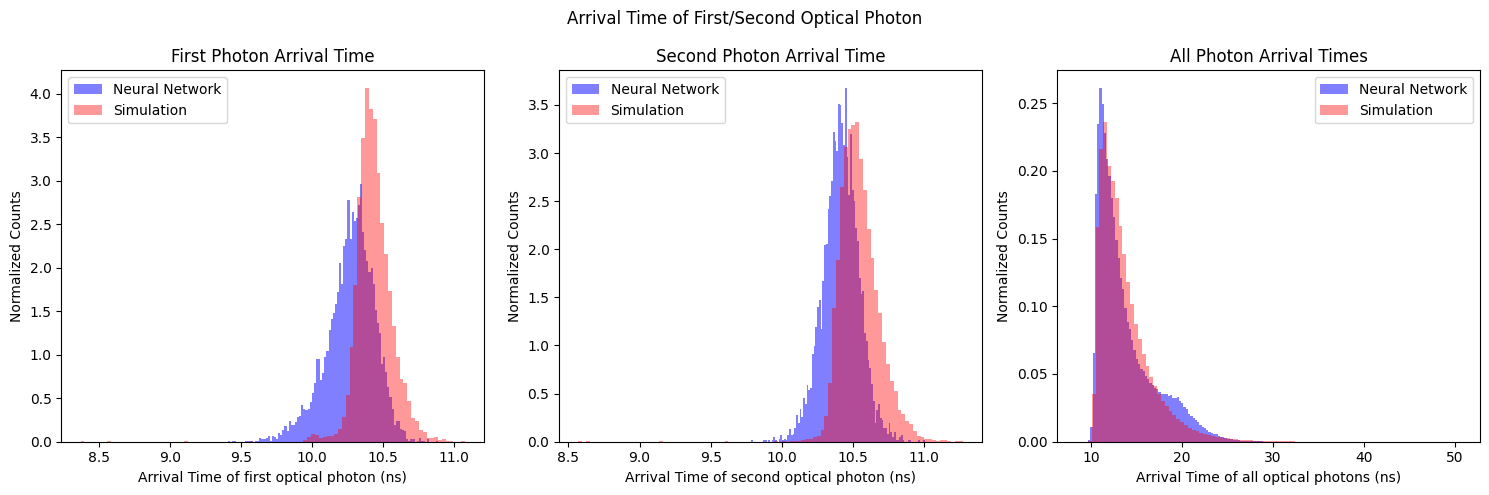

In [30]:
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 600
(mu, sigma) = norm.fit(cut_accepted_times)

fig_first_times, axs_first_times = plot.subplots(1,3,figsize=(15,5))
axs_first_times[0].hist(first_times,bins = 100,alpha = 0.5, color = "blue",density = True,label = "Neural Network");
axs_first_times[0].hist(accepted_times,bins = 100,alpha = 0.4, color = "red",density = True,label = "Simulation");
axs_first_times[0].legend()
axs_first_times[0].set_ylabel("Normalized Counts")
axs_first_times[0].set_title("First Photon Arrival Time")
axs_first_times[0].set_xlabel("Arrival Time of first optical photon (ns)")

axs_first_times[1].hist(second_min_samples,bins = 100,alpha = 0.5, color = "blue",density = True,label = "Neural Network");
axs_first_times[1].hist(second_lowest_list,bins = 100,alpha = 0.4, color = "red",density = True,label = "Simulation");
axs_first_times[1].legend()
axs_first_times[1].set_ylabel("Normalized Counts")
axs_first_times[1].set_title("Second Photon Arrival Time")
axs_first_times[1].set_xlabel("Arrival Time of second optical photon (ns)")

axs_first_times[2].hist(samples,bins = 100,alpha = 0.5, color = "blue",density = True,label = "Neural Network");
axs_first_times[2].hist(all_times_optph,bins = 100,alpha = 0.4, color = "red",density = True,label = "Simulation");
axs_first_times[2].legend()
axs_first_times[2].set_ylabel("Normalized Counts")
axs_first_times[2].set_title("All Photon Arrival Times")
axs_first_times[2].set_xlabel("Arrival Time of all optical photons (ns)")
fig_first_times.suptitle("Arrival Time of First/Second Optical Photon")
# fig_first_times.text(0.3,0.5,r"$\sigma$ = %.1f ps"%(sigma * 1000))
fig_first_times.tight_layout()
# fig_first_times.savefig("plots/time_res/both_times_1cm_new_labels.jpeg")

## Cutting off tails

In [21]:
np_first_times = np.array(first_times)

np_accepted_times = np.array(accepted_times)

cut_first_times = np_first_times[np_first_times < 10.8]
cut_first_times = cut_first_times[cut_first_times > 10]

cut_accepted_times = np_accepted_times[np_accepted_times < 10.8]
cut_accepted_times = cut_accepted_times[cut_accepted_times > 10]

In [18]:
#timing resolution:
(mu_real, sigma_real) = norm.fit(cut_accepted_times)
(mu_learned, sigma_learned) = norm.fit(cut_first_times)
print("\tsigma:\t\t| mean:\t\t")
print("Real:\t\t  %4.3f |\t %4.2f" %(sigma_real,mu_real))
print("Learned:\t  %4.3f |\t %4.2f" %(sigma_learned,mu_learned))

	sigma:		| mean:		
Real:		  0.107 |	 10.44
Learned:	  0.111 |	 10.43


In [97]:
#timing resolution:
accepted_times = np.array(accepted_times)

cut_accepted_times = accepted_times[accepted_times < 10.9]
cut_accepted_times = cut_accepted_times[cut_accepted_times > 10]


(mu_real, sigma_real) = norm.fit(accepted_times)
(mu_real_cut, sigma_real_cut) = norm.fit(cut_accepted_times)
print("\tsigma:\t\t| mean:\t\t")
print("Real:\t\t  %4.3f |\t %4.2f" %(sigma_real,mu_real))
print("Real cut:\t\t  %4.3f |\t %4.2f" %(sigma_real_cut,mu_real_cut))

	sigma:		| mean:		
Real:		  0.125 |	 10.44
Real cut:		  0.117 |	 10.44


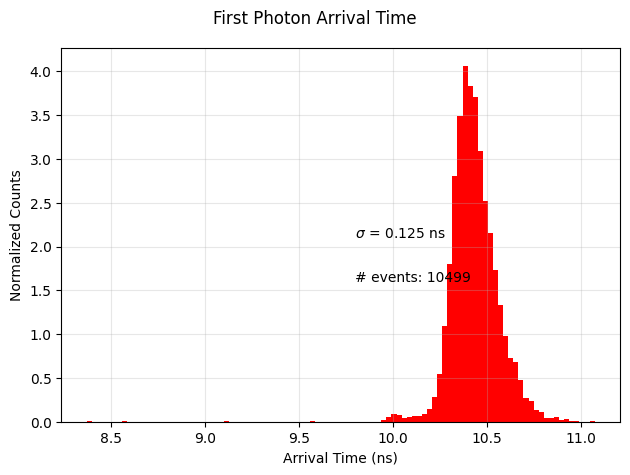

In [98]:
fig_first_times, axs_first_times = plot.subplots(1,1)
axs_first_times.hist(accepted_times,bins = 100,alpha = 1, color = "red",density = True);
# axs_first_times.legend()
axs_first_times.set_ylabel("Normalized Counts")
axs_first_times.set_xlabel("Arrival Time (ns)")
axs_first_times.text(9.8,2.1,r"$\sigma$ = %.3f ns" % (sigma_real))
axs_first_times.text(9.8,1.6,r"# events: %d" % (len(accepted_times)))
axs_first_times.grid(alpha = 0.3)
fig_first_times.suptitle("First Photon Arrival Time")
fig_first_times.tight_layout()
plot.show()
# fig_first_times.savefig("plots/sept_29/time_res_0_8_10GeV_mu_5250.pdf")